In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn import svm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#### loading data, dropping columns

In [3]:
df_train = pd.read_csv('final2/Training/train_engineered_cleaned_merged_flights_Jan_2w.csv')
df_test = pd.read_csv('final2/Validation/vali_engineered_cleaned_merged_flights_Jan_2w.csv')
dftrain_cat = df_train[['op_unique_carrier', 'origin', 'dest']]
dftest_cat = df_test[['op_unique_carrier', 'origin', 'dest']]
df_train.drop(['arr_time_hour', 'arr_time_min', 'cos_arr_time', 'cos_dep_time',
        'dep_time_hour', 'dep_time_min', 'sin_arr_time',
       'sin_dep_time', 'op_unique_carrier', 'origin', 'dest', 'fl_date','crs_dep_time','dep_time','crs_arr_time','arr_time','numflights','numstrikes', 'weekday',
        'crs_dep_time_hour','crs_dep_time_min','dep_time_hour','dep_time_min','crs_arr_time_hour',
        'crs_arr_time_min','arr_time_hour','arr_time_min', 'dep_time', 'dep_delay', 'late_aircraft_delay', 
        'weather_delay', 'arr_delay'], axis=1, inplace=True)

df_test.drop(['origin', 'dest', 'fl_date', 
       'numflights', 'numstrikes', 'crs_arr_time', 'crs_arr_time_hour', 'crs_arr_time_min', 'crs_dep_time',
       'crs_dep_time_hour', 'crs_dep_time_min','op_unique_carrier', 'weekday'], axis=1, inplace=True)

df_test.rename(columns={'dep_delay': 'DelayD_carrier'}, inplace=True)
df_test = df_test.dropna()

In [91]:
(df_test.columns^df_train.columns)&df_train.columns

/tmp/ipykernel_5230/1315710462.py:1: FutureWarning: Index.__xor__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__xor__.  Use index.symmetric_difference(other) instead
  (df_test.columns^df_train.columns)&df_train.columns
/tmp/ipykernel_5230/1315710462.py:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  (df_test.columns^df_train.columns)&df_train.columns


Index(['delay', 'delayed'], dtype='object')

## test with delay instead of arr_delay

In [6]:
def how_delayed(row):
    if row['arr_delay'] <= 15:
        return 0
    else:
        return row['arr_delay']

In [7]:
df_test['delay'] = df_test.apply(lambda x: how_delayed(x), axis=1)

In [108]:
prerem = df_train.columns 
preremtest = df_test.columns 

#### remove covarying features and transform to z-scores

In [8]:
columns_num =  ['delay', 'distance', 'num_flights_carrier', 'num_flights_origin', 'DelayD_origin_hourly',
       'DelayD_carrier_hourly']
df_train[columns_num] = df_train[columns_num].mask((df_train[columns_num]  - df_train[columns_num].mean()).abs() > 3 * df_train[columns_num].std())
df_test[columns_num] = df_test[columns_num].mask((df_test[columns_num]  - df_test[columns_num].mean()).abs() > 3 * df_test[columns_num].std())
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)
df_trainfilter = df_train.copy()
df_valfilter = df_test.copy()

y_train = df_trainfilter['delay']
y_test = df_valfilter['delay']
df_trainfilter.drop(['delay', 'delayed'], axis=1, inplace=True)
df_valfilter.drop(['arr_delay' ,'delay'], axis=1, inplace=True)

# create correlation matrix

df_traincorr = df_trainfilter.corr().abs()
df_valcorr = df_valfilter.corr().abs()

# iterate thru and find pairs with correlation > 0.8

trainindices = np.where(df_traincorr > 0.8) 
trainindices = [(df_traincorr.index[x], df_traincorr.columns[y]) 
for x, y in zip(*trainindices)
    if x != y and x < y]


# drop pairs found in last step

for idx in trainindices: #each pair
    try:
        df_trainfilter.drop(idx[1], axis = 1, inplace=True)
        df_valfilter.drop(idx[1], axis = 1, inplace=True)
    except KeyError:
        pass
    

X_train = df_trainfilter
X_test = df_valfilter

scaler = StandardScaler()
XZ_train = scaler.fit_transform(X_train)
XZ_test = scaler.transform(X_test)

In [96]:
X_test

,distance,strikeprob,percentflights,region_N,region_O,region_S,region_W,man_Aerospatiale/alenia,man_Air Tractor Inc,man_Airbus,...,cos_crs_arr_time,DelayD_carrier,num_flights_carrier,DelayD_origin,DelayD_dest,num_flights_dest,DelayA_hourly,num_flights_hourly,DelayA_origin_hourly,DelayA_carrier_hourly
0,828.0,0.004772,0.004266,0,0,1,0,0.0,0.0,0.0,...,0.136737,8.110217,10536,14.175439,24.569832,1465,5.101982,5916,8.911111,-2.111041
1,129.0,0.010067,0.023722,0,0,0,1,0.0,0.0,0.0,...,-0.145500,4.106047,1494,5.798352,6.771788,1101,1.618029,6207,-1.650847,2.559091
2,2500.0,0.019247,0.020046,1,0,0,0,0.0,0.0,0.0,...,-0.532833,10.985462,7576,20.626907,9.248412,694,11.809281,5007,19.674528,7.735955
3,448.0,0.007340,0.020279,0,0,0,0,0.0,0.0,0.0,...,0.753902,11.132506,17294,7.079280,12.018841,898,1.523037,6104,-10.666667,-5.161731
4,930.0,0.009317,0.004173,0,0,1,0,0.0,0.0,0.0,...,-0.957659,11.132506,17294,15.821835,10.932830,570,7.830983,5745,8.987654,6.345068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96228,573.0,0.003136,0.002652,0,0,0,1,0.0,0.0,0.0,...,-0.275163,7.628542,1248,18.282187,10.890298,1791,8.802185,5482,5.877551,15.395000
96229,1715.0,0.007817,0.008406,0,0,0,1,0.0,0.0,0.0,...,-0.957659,11.132506,17294,8.147135,12.018841,898,3.737804,6096,-2.739496,0.530988
96230,585.0,0.036745,0.049416,0,0,0,0,0.0,0.0,0.0,...,0.660317,15.475187,2582,18.685498,11.494275,216,8.802185,5482,15.768041,8.776961
96231,1107.0,0.000000,0.000393,0,1,0,0,0.0,0.0,0.0,...,0.988705,11.307594,11614,8.074468,10.314575,1265,10.809011,5874,-8.600000,7.512210


In [56]:
prerem

Index(['distance', 'strikeprob', 'percentflights', 'region_N', 'region_O',
       'region_S', 'region_W', 'man_Aerospatiale/alenia',
       'man_Air Tractor Inc', 'man_Airbus', 'man_American Champion Aircraft',
       'man_Atr-gie Avions De Transport', 'man_Avions De Transport Regional',
       'man_Bell Helicopter Textron Canada', 'man_Benham John', 'man_Boeing',
       'man_Bombardier', 'man_Canadair', 'man_Cessna',
       'man_Cirrus Design Corp', 'man_Dassault', 'man_De Havilland Canada',
       'man_Diamond Aircraft Ind Gmbh', 'man_Eads/alenia Atr',
       'man_Ela Aviacion', 'man_Embraer', 'man_Grumman',
       'man_Gulfstream Aerospace', 'man_Mcdonnell Douglas',
       'man_Mooney Aircraft Corp.', 'man_Pilatus', 'man_Piper',
       'man_Quest Aircraft Company Llc', 'man_Robinson Helicopter Co',
       'man_Saab', 'man_Socata', 'man_Tremble Jason M', 'aircraft_age',
       'type_large_airport', 'type_medium_airport', 'type_small_airport',
       'date', 'sin_weekday', 'cos_weekda

In [97]:
prerem ^df_trainfilter.columns

/tmp/ipykernel_5230/913826926.py:1: FutureWarning: Index.__xor__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__xor__.  Use index.symmetric_difference(other) instead
  prerem ^df_trainfilter.columns


Index(['DelayA_carrier', 'DelayA_dest', 'DelayA_origin',
       'DelayD_carrier_hourly', 'DelayD_hourly', 'DelayD_origin_hourly',
       'delay', 'delayed', 'num_flights_origin', 'type_medium_airport'],
      dtype='object')

In [80]:
(X_train.columns^X_test.columns)

/tmp/ipykernel_5230/693546722.py:1: FutureWarning: Index.__xor__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__xor__.  Use index.symmetric_difference(other) instead
  (X_train.columns^X_test.columns)


Index([], dtype='object')

### linear regression

MSE: 550.2060469958134
MAE: 13.765561919128782
R^2: 0.03136563952931848


<function matplotlib.pyplot.show(close=None, block=None)>

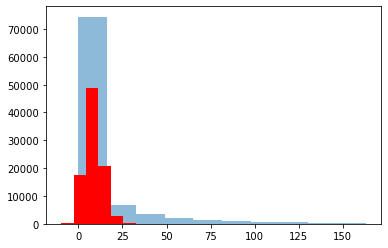

In [98]:
#unstandardized
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))
plt.hist(y_test, alpha=0.5)
plt.hist(y_pred, color='r')
plt.show

MSE: 530.1927286199656
MAE: 13.25071223016713
R^2: 0.028639115907768242


<function matplotlib.pyplot.show(close=None, block=None)>

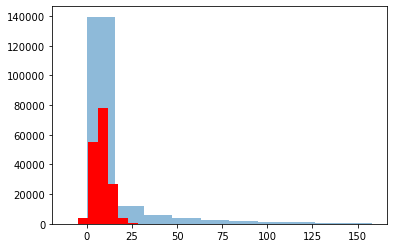

In [60]:
#standardized
lin_reg = LinearRegression()
lin_reg.fit(XZ_train,y_train)
y_pred = lin_reg.predict(XZ_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))
plt.hist(y_test, alpha=0.5)
plt.hist(y_pred, color='r')
plt.show

### Gradient Descent

MSE: 1.3512322115168733e+22
MAE: 3675298132.18735
R^2: -2.4721807587111707e+19


<function matplotlib.pyplot.show(close=None, block=None)>

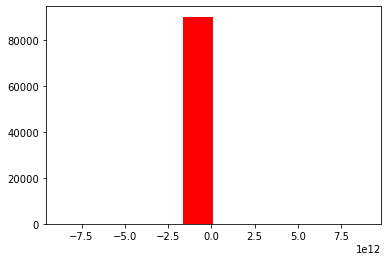

In [74]:
from sklearn import linear_model
SGDClf = linear_model.SGDRegressor()
SGDClf.fit(XZ_train, y_train)
y_pred = SGDClf.predict(XZ_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))
plt.hist(y_test, alpha=0.5)
plt.hist(y_pred, color='r')
plt.show

### Random Forest Regressor

In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics


MAE: 14.839406436394366
MSE: 522.2351101077043
RMSE: 22.85246398329301
r^2: 0.04321819052740428



<function matplotlib.pyplot.show(close=None, block=None)>

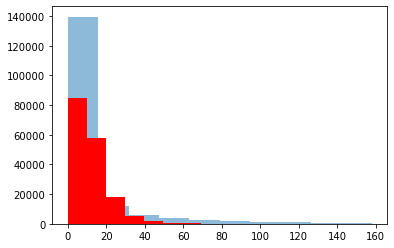

In [62]:
X_train_arr = np.array(XZ_train)
y_train_arr = np.array(y_train)
X_val_arr = np.array(XZ_test)

clf=RandomForestRegressor(n_estimators=100)
clf.fit(X_train_arr,y_train_arr)

y_pred = clf.predict(X_val_arr)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y_test,y_pred)

print(f'''
MAE: {mae}
MSE: {mse}
RMSE: {rmse}
r^2: {r2}
''')
plt.hist(y_test, alpha=0.5)
plt.hist(y_pred, color='r')
plt.show


mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y_test,y_pred)

print(f'''
MAE: {mae}
MSE: {mse}
RMSE: {rmse}
r^2: {r2}
''')
plt.hist(y_test, alpha=0.5)
plt.hist(y_pred, color='r')
plt.show



In [ ]:
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
SGDClf = linear_model.SGDClassifier()
SGDclf = make_pipeline(StandardScaler(),
                   linear_model.SGDClassifier())
SGDClf.fit(X_train, y_train)

In [122]:
yz_test = scaler.fit_transform(np.array(y_test).reshape(-1, 1))

MSE: 2.1679643346635897
MAE: 0.6469795073213613
R^2: -1.1679643346635897


<function matplotlib.pyplot.show(close=None, block=None)>

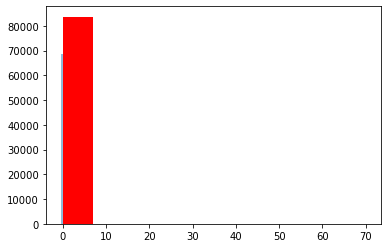

In [134]:
y_pred = SGDClf.predict(XZ_test)
print("MSE:", mean_squared_error(yz_test, y_pred))
print("MAE:", mean_absolute_error(yz_test, y_pred))
print("R^2:", r2_score(yz_test, y_pred))
plt.hist(yz_test, alpha=0.5)
plt.hist(y_pred, color='r')
plt.show

In [68]:
y_pred = SGDClf.predict(XZ_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))
plt.hist(y_test, alpha=0.5)
plt.hist(y_pred, color='r')
plt.show

NameError: name 'SGDClf' is not defined

In [124]:
import matplotlib.pyplot as plt

### Lasso Regression

MSE: 544.2020304981953
MAE: 14.42854473675977
R^2: 0.004341535686970932


<function matplotlib.pyplot.show(close=None, block=None)>

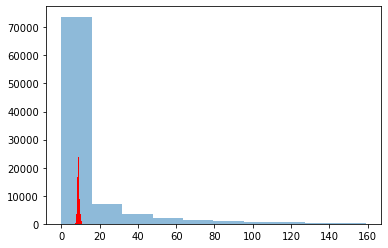

In [67]:
from sklearn.linear_model import Lasso
clf = Lasso(alpha=3)
clf.fit(XZ_train,y_train)
y_pred = clf.predict(XZ_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))
plt.hist(y_test, alpha=0.5)
plt.hist(y_pred, color='r')
plt.show

### SVR

In [ ]:
from sklearn import svm
SVMclf = svm.SVR(kernel='poly')
SVMclf.fit(XZ_train, y_train)
y_pred = SVMclf.predict(XZ_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))
plt.hist(y_test, alpha=0.5)
plt.hist(y_pred, color='r')
plt.show

In [83]:
len(X_test.columns)

55

### xgboost

In [9]:
import xgboost as xgb

In [10]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 15, alpha = 10, n_estimators = 200)

MSE: 499.02695193914394
MAE: 13.210990530805613
R^2: 0.08573762887474523


<function matplotlib.pyplot.show(close=None, block=None)>

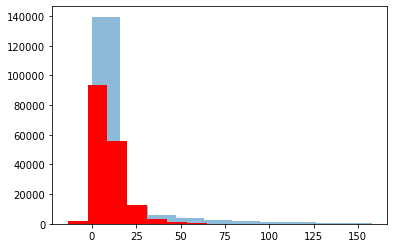

In [11]:
xg_reg.fit(XZ_train,y_train)
y_pred = xg_reg.predict(XZ_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))
plt.hist(y_test, alpha=0.5)
plt.hist(y_pred, color='r')
plt.show